# NEACRP C1 Rod Ejection Accident

**Inputs**

- `rod_worth`: Reactivity worth of the rod being ejected
- `beta`: Delayed neutron fraction 
- `h_gap`: Gap conductancce ($\frac{W}{m^2 \cdot K}$)
- `gamma_frac`: Direct heating fraction

**Outputs**

- `max_power`: Peak power reached during transient ($\% FP$)
- `burst_width`: Width of power burst ($s$)
- `max_TF`: Max fuel centerline temperature ($K$)
- `avg_Tcool`: Average coolant temperature at outlet ($K$)

The NEACRP C1 rod ejection accident (REA) data represents one benchmark for reactor transient analysis. The data set is used to find the relationship between the REA/reactor parameters and the power/thermal behavior of the system during/after the event. Therefore, the data set is constructed by perturbing the inputs listed above. The corresponding output results in values of interest to the safety analysis of the transient. The data were generated using deterministic simulations by the PARCS code, where the data set size includes 2000 simulations/samples [1]. The goal is to use pyMAISE to build, tune, and compare various ML models' performance in predicting the transient outcomes based on the REA properties.

In [6]:
import pyMAISE as mai
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import uniform, randint, norm
from sklearn.model_selection import ShuffleSplit
from statistics import stdev, mean

# Plot settings
matplotlib_settings = {
    "font.size": 14,
    "legend.fontsize": 12,
}
plt.rcParams.update(**matplotlib_settings)

## pyMAISE Initialization

First we initialize pyMAISE with the following 4 parameters:

- `verbosity`: 0 $\rightarrow$ pyMAISE prints no outputs,
- `random_state`: None $\rightarrow$ No random seed is set,
- `test_size`: 0.3 $\rightarrow$ 30% of the data is used for testing,
- `num_configs_saved`: 5 $\rightarrow$ The top 5 hyper-parameter configurations are saved for each model.

With pyMAISE initialized we can load the preprocessor for this data set using `load_rea()`.

In [7]:
global_settings = mai.settings.init()
preprocessor = mai.load_rea()

As stated the data set consists of 4 inputs:

In [8]:
preprocessor.inputs.head()

,rod_worth,beta,h_gap,gamma_frac
0,0.008638,0.007576,13727.981902,0.023957
1,0.009255,0.007529,9370.218080,0.019707
2,0.008046,0.007647,9962.543845,0.020045
3,0.008463,0.007139,8569.910206,0.020072
4,0.008641,0.007575,12813.925869,0.011449


and 4 outputs with 2000 total data points:

In [9]:
preprocessor.outputs.head()

,max_power,burst_width,max_Tf,avg_Tcool
0,181.210,0.315,918.3,561.119081
1,474.590,0.250,965.2,562.030035
2,44.083,0.425,875.7,560.194700
3,270.500,0.290,938.2,561.241696
4,195.560,0.315,924.8,561.106714


Prior to constructing any models we can get a surface understanding of the data set with a correlation matrix.

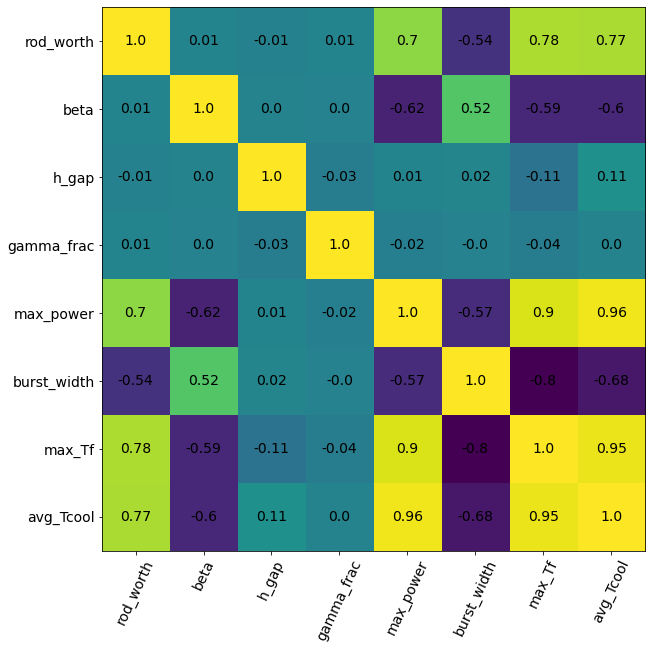

In [10]:
fig, ax = plt.subplots(figsize=(15,10))
fig, ax = preprocessor.correlation_matrix(fig=fig, ax=ax, annotations=True, colorbar=False)

There is a positive correlation between rod worth and maximum power, maximum fuel centerline temperature, and average coolant outlet temperature. Additionally, the delayed neutron fraction correlates with burst width.

The final step of the pyMAISE initialization process is data scaling. For this data set we will use min-max scaling.

In [11]:
data = preprocessor.min_max_scale()

## Model Initialization

We will examine the performance of 6 models in this data set:

- Linear regression: `linear`,
- Lasso regression: `lasso`,
- Decision tree regression: `dtree`,
- Random forest regression: `rforest`,
- K-nearest neighbors regression: `knn`,
- Sequential dense neural networks: `nn`.

For hyper-parameter tuning, each model must be initialized. We will use the Scikit-learn defaults for the classical ML models (`linear`, `lasso`, `dtree`, `rforest`, and `knn`); therefore, they are only specified in the `models` parameter of the `model_settings` dictionary. However, we must specify `nn` model parameters that define the layers, optimizer, and training.

In [12]:
model_settings = {
    "models": ["linear", "lasso", "dtree", "knn", "rforest", "nn"],
    "nn": {
        # Sequential
        "num_layers": 4,
        "dropout": True,
        "rate": 0.5,
        "validation_split": 0.15,
        "loss": "mean_absolute_error",
        "metrics": ["mean_absolute_error"],
        "batch_size": 8,
        "epochs": 75,
        "warm_start": True,
        "jit_compile": False,
        # Starting Layer
        "start_num_nodes": 100,
        "start_kernel_initializer": "normal",
        "start_activation": "relu",
        "input_dim": preprocessor.inputs.shape[1], # Number of inputs
        # Middle Layers
        "mid_num_node_strategy": "linear", # Middle layer nodes vary linearly from 'start_num_nodes' to 'end_num_nodes'
        "mid_kernel_initializer": "normal",
        "mid_activation": "relu",
        # Ending Layer
        "end_num_nodes": preprocessor.outputs.shape[1], # Number of outputs
        "end_activation": "linear",
        "end_kernel_initializer": "normal",
        # Optimizer
        "optimizer": "adam",
        "learning_rate": 5e-4,
    },
}
tuning = mai.Tuning(data=data, model_settings=model_settings)

## Hyper-parameter Tuning

We will use random search for the hyper-parameter tuning of the classical models (`lasso`, `dtree`, `rforest`, and `knn`) through the `random_search` function. `linear` will be manually fit with the Scikit-learn defaults. For each classical model 300 models will be produced with randomly sampled parameter configurations. For `nn`, bayesian search is used to optimize the hyper-parameters in 50 iterations through the `bayesian_search` function. Bayesian search is appealing for `nn` as their training can be computationally expensive. To further reduce the computational cost of `nn` we specify only 10 epochs which will produce less than performant models but show the optimal parameters. For both search methods we use cross-validation to reduce bias in the models from the data set. The hyper-parameter search spaces are defined in the `random_search_spaces` and `bayesian_search_spaces` dictionaries.

In [13]:
random_search_spaces = {
    "lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "dtree": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "rforest": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "knn": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}
bayesian_search_spaces = {
    "nn": {
        "mid_num_node_strategy": ["constant", "linear"],
        "batch_size": [8, 64],
        "dropout": [True, False],
        "learning_rate": [1e-5, 0.01],
        "num_layers": [2, 6],
        "start_num_nodes": [25, 500],
    },
}

start = time.time()
random_search_configs = tuning.random_search(
    param_spaces=random_search_spaces, 
    models=["linear"] + list(random_search_spaces.keys()), 
    n_iter=300, 
    cv=ShuffleSplit(n_splits=5, test_size=0.25, random_state=global_settings.random_state),
)
bayesian_search_configs = tuning.bayesian_search(
    param_spaces=bayesian_search_spaces,
    models=bayesian_search_spaces.keys(),
    n_iter=50,
    cv=ShuffleSplit(n_splits=5, test_size=0.25, random_state=global_settings.random_state),
)
stop = time.time()
print("Hyper-parameter tuning took " + str((stop - start) / 60) + " minutes to process.")

Hyper-parameter tuning search space was not provided for linear, doing manual fit
Hyper-parameter tuning took 108.24320970773697 minutes to process.


We can understand the hyper-parameter tuning of Bayesian search from the convergence plot.

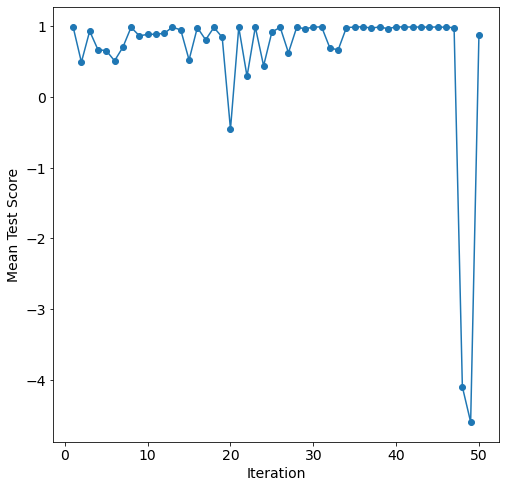

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
ax = tuning.convergence_plot(model_types="nn")

Fewer than 30 iterations were required to converge to the optimal parameter configurations.

## Model Post-processing

Now that the top `num_configs_saved` saved, we can pass these models to the `PostProcessor` for model comparison and analysis. To improve the `nn` performance we can pass an updated epochs parameter. Using 500 epochs should improve fitting at higher computational cost.

In [15]:
new_model_settings = {
    "nn": {"epochs": 500}
}
postprocessor = mai.PostProcessor(
    data=data, 
    models_list=[random_search_configs, bayesian_search_configs], 
    new_model_settings=new_model_settings,
    yscaler=preprocessor.yscaler,
)

To compare the performance of these models we will compute 4 metrics for both the training and testing data: 

- mean squared error `MSE` $=\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y_i})^2$, 
- root mean squared error `RMSE` $=\sqrt{\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y_i})^2}$,
- mean absolute error `MAE` = $=\frac{1}{n}\sum^n_{i = 1}|y_i - \hat{y_i}|$,
- and r-squared `R2` $=1 - \frac{\sum^n_{i = 1}(y_i - \hat{y_i})^2}{\sum^n_{i = 1}(y_i - \bar{y_i})^2}$,

where $y$ is the actual outcome, $\bar{y}$ is the average outcome, $\hat{y}$ is the model predicted outcome, and $n$ is the number of observations. The averaged performance metrics are shown below.

In [16]:
postprocessor.metrics()[["Model Types", "Train R2", "Test R2"]]

,Model Types,Train R2,Test R2
22,nn,0.996991,0.996563
25,nn,0.997542,0.996274
23,nn,0.993635,0.994332
21,nn,0.994222,0.993968
24,nn,0.990929,0.991919
12,rforest,0.995286,0.986470
11,rforest,0.996907,0.986128
13,rforest,0.993114,0.984042
15,rforest,0.990654,0.983169
14,rforest,0.990818,0.981383


Given the top performing models are `linear` and `lasso` this data set's outputs are linear with their inputs. `nn` also performs well with all models greater than 0.95. Performance quickly drops off with `rforest`, `knn`, and `dtree`. We can look specifically at the performance for each output:

In [17]:
postprocessor.metrics(y="max_power")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
21,nn,"{'batch_size': 8, 'dropout': 0, 'learning_rate...",0.999765,2.133878,10.063103,3.172239,0.999828,2.030514,7.801756,2.793162
22,nn,"{'batch_size': 8, 'dropout': 0, 'learning_rate...",0.999833,2.112485,7.136338,2.671393,0.999809,2.219746,8.629569,2.937613
23,nn,"{'batch_size': 13, 'dropout': 0, 'learning_rat...",0.999527,3.283176,20.276449,4.502938,0.999619,3.345278,17.225367,4.150345
25,nn,"{'batch_size': 21, 'dropout': 0, 'learning_rat...",0.999574,3.959537,18.271895,4.274564,0.999582,3.942873,18.888371,4.346075
24,nn,"{'batch_size': 8, 'dropout': 0, 'learning_rate...",0.999397,3.839394,25.836482,5.082960,0.999391,3.985900,27.552767,5.249073
12,rforest,"{'criterion': 'poisson', 'max_features': None,...",0.998844,3.694867,49.532222,7.037913,0.991611,10.021148,379.428960,19.478936
11,rforest,"{'criterion': 'squared_error', 'max_features':...",0.998732,4.066483,54.318439,7.370104,0.990279,10.491619,439.651007,20.967857
14,rforest,"{'criterion': 'absolute_error', 'max_features'...",0.996685,6.143280,142.022579,11.917323,0.989230,11.197654,487.118868,22.070770
15,rforest,"{'criterion': 'squared_error', 'max_features':...",0.997262,5.726082,117.322278,10.831541,0.988743,11.284735,509.128735,22.563881
13,rforest,"{'criterion': 'poisson', 'max_features': 6, 'm...",0.997948,4.804165,87.931383,9.377174,0.987344,11.140833,572.401047,23.924904


For max power all but `linear` and `lasso` did well.

In [18]:
postprocessor.metrics(y="burst_width")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
22,nn,"{'batch_size': 8, 'dropout': 0, 'learning_rate...",0.988799,0.005160,0.000172,0.013098,0.987108,0.005698,0.000239,0.015456
25,nn,"{'batch_size': 21, 'dropout': 0, 'learning_rat...",0.991330,0.005005,0.000133,0.011524,0.986333,0.005875,0.000253,0.015914
23,nn,"{'batch_size': 13, 'dropout': 0, 'learning_rat...",0.977841,0.005919,0.000339,0.018422,0.980524,0.006991,0.000361,0.018997
21,nn,"{'batch_size': 8, 'dropout': 0, 'learning_rate...",0.978727,0.006273,0.000326,0.018050,0.977655,0.007223,0.000414,0.020349
12,rforest,"{'criterion': 'poisson', 'max_features': None,...",0.985973,0.002829,0.000215,0.014657,0.974381,0.006673,0.000475,0.021788
11,rforest,"{'criterion': 'squared_error', 'max_features':...",0.992650,0.003202,0.000113,0.010610,0.973837,0.006776,0.000485,0.022018
13,rforest,"{'criterion': 'poisson', 'max_features': 6, 'm...",0.982523,0.004071,0.000268,0.016361,0.973693,0.006995,0.000487,0.022079
24,nn,"{'batch_size': 8, 'dropout': 0, 'learning_rate...",0.967319,0.007959,0.000501,0.022373,0.971284,0.008661,0.000532,0.023067
15,rforest,"{'criterion': 'squared_error', 'max_features':...",0.975306,0.004684,0.000378,0.019448,0.968105,0.007372,0.000591,0.024311
14,rforest,"{'criterion': 'absolute_error', 'max_features'...",0.978055,0.004783,0.000336,0.018333,0.961587,0.007456,0.000712,0.026679


For burst width `knn`, `dtree`, `lasso`, and `linear` struggled to predict the testing data. `knn` overfit to the training data set.

In [19]:
postprocessor.metrics(y="max_Tf")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
22,nn,"{'batch_size': 8, 'dropout': 0, 'learning_rate...",0.999606,0.476851,0.494479,0.703192,0.999593,0.514516,0.534188,0.730882
25,nn,"{'batch_size': 21, 'dropout': 0, 'learning_rat...",0.999654,0.531952,0.435127,0.659641,0.999570,0.561521,0.563811,0.750873
21,nn,"{'batch_size': 8, 'dropout': 0, 'learning_rate...",0.998736,0.796847,1.587985,1.260153,0.998745,0.810594,1.645989,1.282961
24,nn,"{'batch_size': 8, 'dropout': 0, 'learning_rate...",0.997993,1.064926,2.520588,1.587636,0.998061,1.124524,2.543935,1.594972
23,nn,"{'batch_size': 13, 'dropout': 0, 'learning_rat...",0.997786,1.214482,2.780910,1.667606,0.997780,1.280105,2.911773,1.706392
11,rforest,"{'criterion': 'squared_error', 'max_features':...",0.997825,1.095227,2.731355,1.652681,0.989698,2.461387,13.514313,3.676182
12,rforest,"{'criterion': 'poisson', 'max_features': None,...",0.997872,0.985909,2.672958,1.634918,0.989633,2.511683,13.599902,3.687805
15,rforest,"{'criterion': 'squared_error', 'max_features':...",0.993997,1.777071,7.538544,2.745641,0.987258,2.768031,16.714941,4.088391
13,rforest,"{'criterion': 'poisson', 'max_features': 6, 'm...",0.995041,1.633966,6.227993,2.495595,0.986598,2.791944,17.581126,4.192985
14,rforest,"{'criterion': 'absolute_error', 'max_features'...",0.993344,1.943850,8.359785,2.891329,0.986437,2.910056,17.792976,4.218172


For max fuel temperature, all models were able to model this output. This indicates the max fuel temperature in linear with the inputs.

In [20]:
postprocessor.metrics(y="avg_Tcool")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
22,nn,"{'batch_size': 8, 'dropout': 0, 'learning_rate...",0.999727,0.010189,0.000152,0.012345,0.999743,0.010191,0.000151,0.012292
21,nn,"{'batch_size': 8, 'dropout': 0, 'learning_rate...",0.999660,0.010413,0.000190,0.013768,0.999643,0.010754,0.000210,0.014492
25,nn,"{'batch_size': 21, 'dropout': 0, 'learning_rat...",0.999613,0.013282,0.000216,0.014697,0.999611,0.013677,0.000229,0.015138
23,nn,"{'batch_size': 13, 'dropout': 0, 'learning_rat...",0.999386,0.014937,0.000343,0.018511,0.999404,0.015323,0.000351,0.018739
24,nn,"{'batch_size': 8, 'dropout': 0, 'learning_rate...",0.999008,0.017018,0.000554,0.023529,0.998942,0.017794,0.000623,0.024961
11,rforest,"{'criterion': 'squared_error', 'max_features':...",0.998422,0.019401,0.000881,0.029684,0.990699,0.046547,0.005477,0.074007
12,rforest,"{'criterion': 'poisson', 'max_features': None,...",0.998453,0.018792,0.000863,0.029384,0.990254,0.049577,0.005739,0.075758
15,rforest,"{'criterion': 'squared_error', 'max_features':...",0.996052,0.029694,0.002204,0.046951,0.988569,0.051719,0.006732,0.082046
13,rforest,"{'criterion': 'poisson', 'max_features': 6, 'm...",0.996944,0.026526,0.001706,0.041308,0.988534,0.051929,0.006752,0.082171
14,rforest,"{'criterion': 'absolute_error', 'max_features'...",0.995187,0.034239,0.002687,0.051836,0.988280,0.055895,0.006901,0.083074


Average coolant temperature was also well predicted by all models.

We can see the parameters of each model with the best `Test R2` with `get_params`.

In [21]:
for model in model_settings["models"]:
    print(postprocessor.get_params(model_type=model), "\n")

  Model Types  copy_X  fit_intercept n_jobs   normalize  positive
0      linear    True           True   None  deprecated     False 

  Model Types     alpha
0       lasso  0.000155 

  Model Types  max_depth  max_features  min_samples_leaf  min_samples_split
0       dtree         37             6                 1                  4 

  Model Types  leaf_size  n_neighbors  p   weights
0         knn         28            5  2  distance 

  Model Types      criterion  max_features  min_samples_leaf  \
0     rforest  squared_error             4                 1   

   min_samples_split  n_estimators  
0                  3           186   

  Model Types  batch_size  dropout  learning_rate mid_num_node_strategy  \
0          nn           8        0       0.002693              constant   

   num_layers  start_num_nodes  
0           2              310   



We can visualize the performance of each model with diagonal validation plots. These plots show the predicted output to the actual output. For the plots below we will do max burst width.

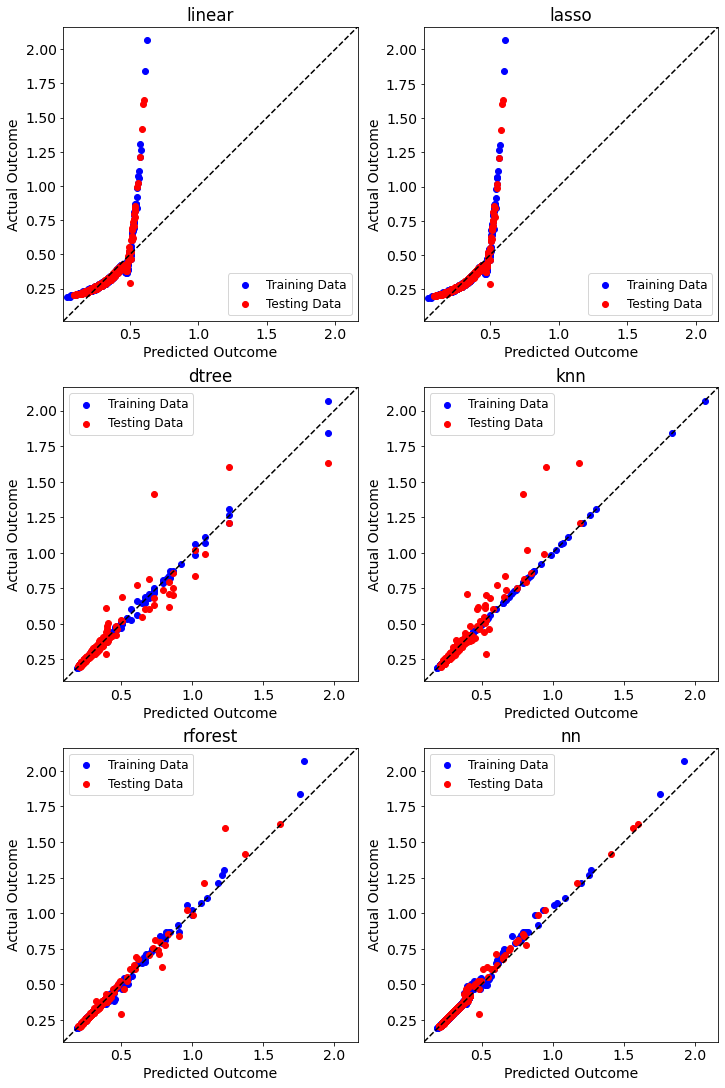

In [27]:
models = np.array([["linear", "lasso"], ["dtree", "knn"], ["rforest", "nn"]])

output = ["burst_width"]

fig = plt.figure(constrained_layout=fig, figsize=(10,15))
gs = GridSpec(models.shape[0], models.shape[1], figure=fig)
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        if models[i, j] != None:
            ax = fig.add_subplot(gs[i, j])
            ax = postprocessor.diagonal_validation_plot(
                model_type=models[i, j], 
                y=output,
            )
            ax.set_title(models[i, j])

We see that all models except `linear` and `lasso` do relatively well predicting burst width. `nn` has the best performance according to these diagonal validation plots.

Similarly, the `validation_plot` function produces validation plots that show the absolute relative error for each burst width prediction.

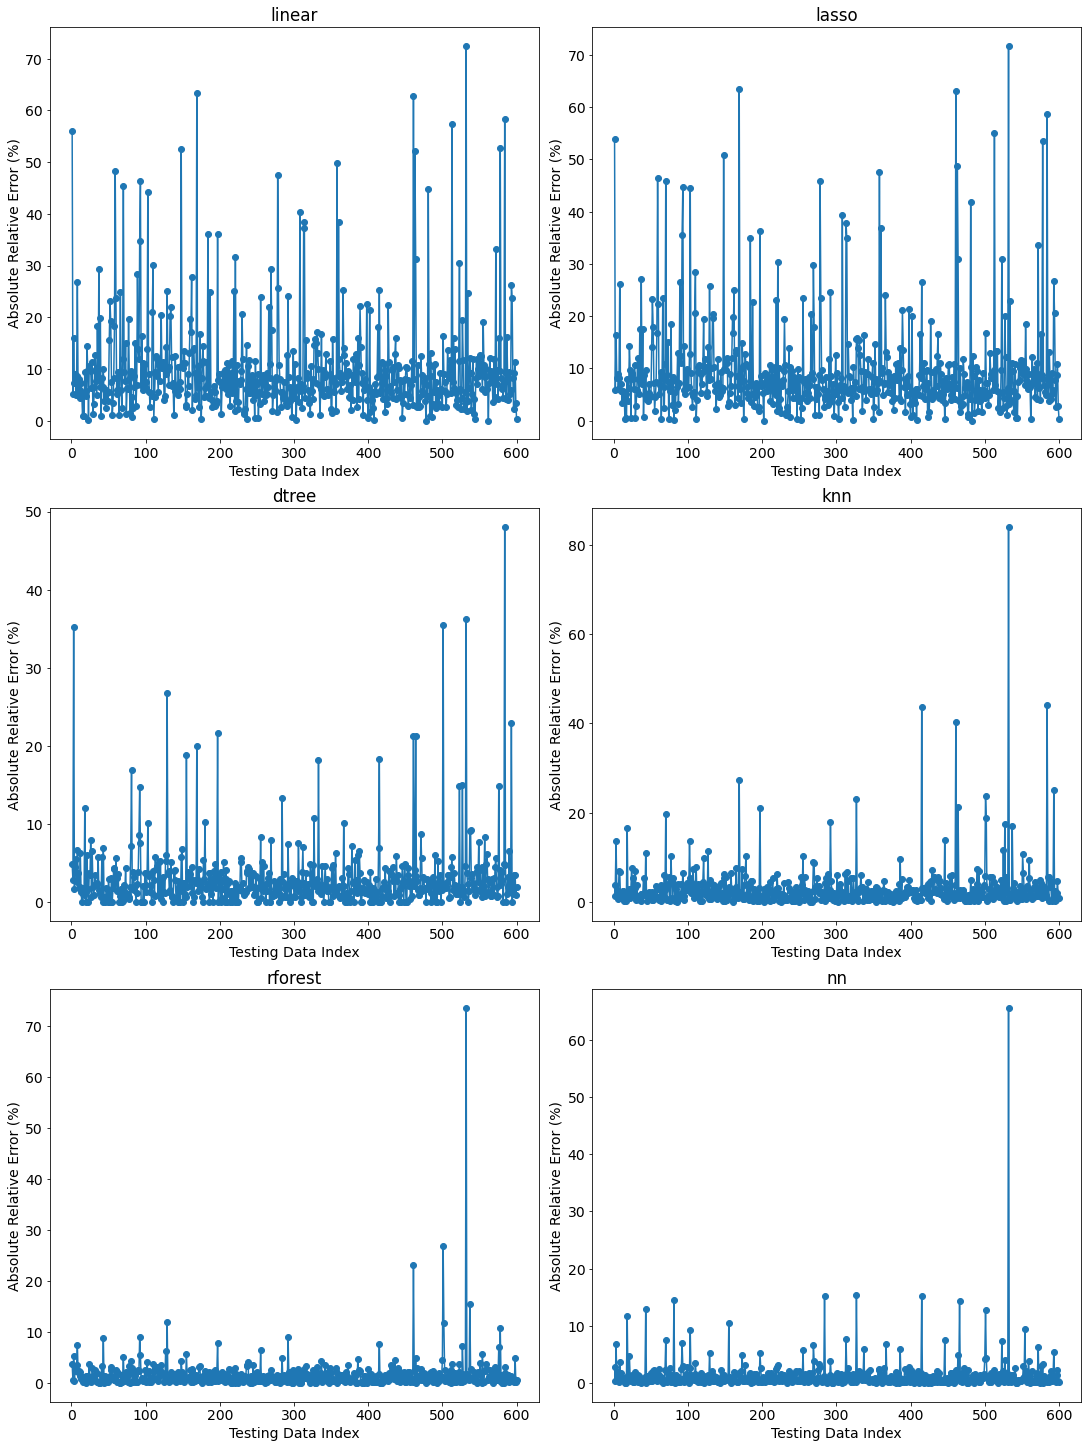

In [26]:
fig = plt.figure(constrained_layout=fig, figsize=(15,20))
gs = GridSpec(models.shape[0], models.shape[1], figure=fig)
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        if models[i, j] != None:
            ax = fig.add_subplot(gs[i, j])
            ax = postprocessor.validation_plot(
                model_type=models[i, j],
                y=output,
            )
            ax.set_title(models[i, j])

The performance gap of the linear model to the others is evident in the magnitude of the relative error.

Finally, the learning curve of the most performant `nn` is shown by `nn_learning_plot`.

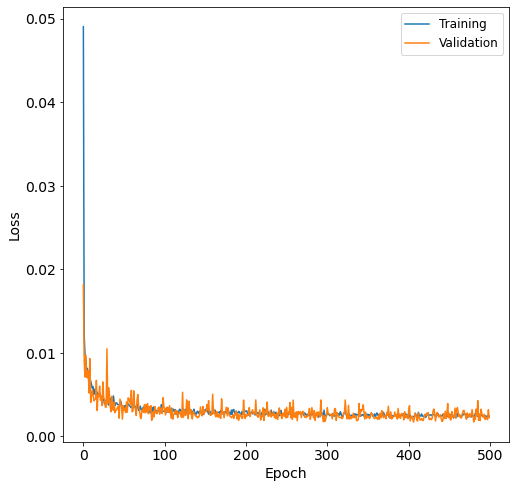

In [24]:
fig, ax = plt.subplots(figsize=(8,8))
ax = postprocessor.nn_learning_plot()

The validation curve is below the training curve; therefore, the `nn` is not overfit.

## References

1. H. Finnemann and A. Galati, “NEACRP 3-D LWR Core Transient Benchmark,” NEACRP-L-335, Revision 1, 1992.

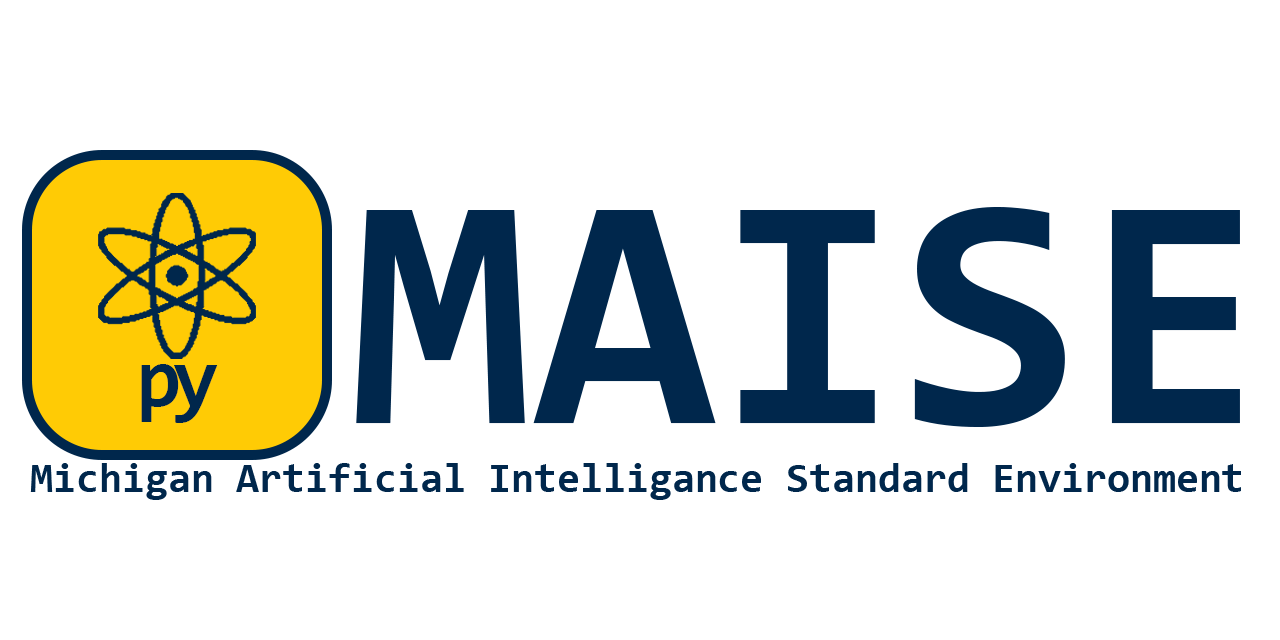